## Import modules

In [1]:
# local
import DBSCAN as ds

import numpy as np
import pandas as pd

from collections import Counter

# nltk 
import nltk
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
import stop_words as sw

# sklearn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA


# data scraping
import itertools
import snscrape.modules.twitter as sc_twt

# visualisation
import seaborn as sns
import wordcloud as wc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

## Data Scrapping

In [3]:
def  scrape_and_save(search_str: str, file_name: str, num_tweets: int = 2000, slice: bool = True):

    scraped_tweets = sc_twt.TwitterSearchScraper(search_str).get_items()

    if(slice):
        sliced_scraped_tweets = itertools.islice(scraped_tweets, num_tweets)
        df = pd.DataFrame(sliced_scraped_tweets)
    else:
        df = pd.DataFrame(scraped_tweets)

    if df.empty == False:
        scr = pd.DataFrame.copy( df[['id', 'date', 'user', 'media', 'lang', 'content', 'hashtags', 'likeCount', 'replyCount', 'quoteCount']])

        scr['user_name'] = scr['user'].apply(lambda x: x['username'])
        scr['user_location'] =  scr['user'].apply(lambda x: x['location'])
        scr['user_isprotected'] = scr['user'].apply(lambda x: x['protected'])
        scr['user_isverified'] = scr['user'].apply(lambda x: x['verified'])

        scr = scr.drop(columns=['user'])

        print("num scraped tweets:" + str(scr.count()))
        print(scr.head(5))
        scr.to_csv(file_name)
    else:
        print("empty df")

In [4]:
# get tweets in english
from os.path import exists

tweets_file = "data/scraped_tweets.csv"
file_exists = exists(tweets_file)

if not file_exists:
    en_search = '(WorldCup OR WorldCup2022 OR FifaWorldCup) until:2022-11-10 lang:en'
    scrape_and_save(search_str = en_search, file_name = "data/scraped_tweets.csv", slice = True, num_tweets=60000)

## Data preprocessing

In [2]:
from os.path import exists

tweets_file = "data/tweets_processed.csv"
tweets_processed_file = exists(tweets_file)
tweets_processed_file

False

### Read data

In [3]:
if not tweets_processed_file:
    df_en_tweets = pd.read_csv("data/scraped_tweets.csv", delimiter=',')
    print(df_en_tweets.head(2))

   Unnamed: 0                   id                       date  \
0           0  1590494205247623168  2022-11-09 23:59:03+00:00   
1           1  1590494197261684737  2022-11-09 23:59:01+00:00   

                                               media lang  \
0                                                NaN   en   
1  [{'previewUrl': 'https://pbs.twimg.com/media/F...   en   

                                             content  \
0  .@MinkysHighjinks: "There can never again be a...   
1  The #LesBleus French National Team has announc...   

                                            hashtags  likeCount  replyCount  \
0                                   ['WorldCup2022']          1           0   
1  ['LesBleus', 'FIFAWorldCup', 'France', 'FIFA',...          1           0   

   quoteCount      user_name user_location  user_isprotected  user_isverified  
0           0  jftaveira1993      Portugal             False            False  
1           0   JustinSibbet        Canada           

### clean columns

#### Ensure that pl tweets in en are just in english

In [4]:
if not tweets_processed_file:
    df_en_tweets = df_en_tweets.loc[df_en_tweets['lang'] == 'en']
    df_en_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59263 entries, 0 to 59999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        59263 non-null  int64 
 1   id                59263 non-null  int64 
 2   date              59263 non-null  object
 3   media             14799 non-null  object
 4   lang              59263 non-null  object
 5   content           59263 non-null  object
 6   hashtags          31367 non-null  object
 7   likeCount         59263 non-null  int64 
 8   replyCount        59263 non-null  int64 
 9   quoteCount        59263 non-null  int64 
 10  user_name         59263 non-null  object
 11  user_location     37200 non-null  object
 12  user_isprotected  59263 non-null  bool  
 13  user_isverified   59263 non-null  bool  
dtypes: bool(2), int64(5), object(7)
memory usage: 6.0+ MB


##### add new, simpler index

In [5]:
# create new index
if not tweets_processed_file:
    df_en_tweets.insert(0, 'ID', range(0, len(df_en_tweets)))
    df_en_tweets = df_en_tweets.set_index('ID')
    print(df_en_tweets.head(3))

    Unnamed: 0                   id                       date  \
ID                                                               
0            0  1590494205247623168  2022-11-09 23:59:03+00:00   
1            1  1590494197261684737  2022-11-09 23:59:01+00:00   
2            2  1590494185588551680  2022-11-09 23:58:58+00:00   

                                                media lang  \
ID                                                           
0                                                 NaN   en   
1   [{'previewUrl': 'https://pbs.twimg.com/media/F...   en   
2                                                 NaN   en   

                                              content  \
ID                                                      
0   .@MinkysHighjinks: "There can never again be a...   
1   The #LesBleus French National Team has announc...   
2   The US Men's National Team  has set it's roste...   

                                             hashtags  likeCount  replyC

In [6]:
if not tweets_processed_file:
    df_en_tweets = df_en_tweets[['lang', 'content', 'user_location']]
    print(df_en_tweets.head(3))

   lang                                            content user_location
ID                                                                      
0    en  .@MinkysHighjinks: "There can never again be a...      Portugal
1    en  The #LesBleus French National Team has announc...        Canada
2    en  The US Men's National Team  has set it's roste...  New York, NY


#### Encode location column

In [7]:
if not tweets_processed_file:
    oe = OrdinalEncoder()
    df_en_tweets['location'] = df_en_tweets['user_location']
    df_en_tweets['location'] = oe.fit_transform(np.array(df_en_tweets['location']).reshape(-1, 1))
    df_en_tweets = df_en_tweets.drop(columns = ['user_location'])
    df_en_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59263 entries, 0 to 59262
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   lang      59263 non-null  object 
 1   content   59263 non-null  object 
 2   location  37200 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.8+ MB


### Clean text content

In [8]:
if not tweets_processed_file:
    white_spaces = ["\r", "\n","\t", "    "]
    punctuation_signs = list("?:!.,;")
    special_characters = list("@#")


    df_en_tweets['content_clean_1'] = df_en_tweets['content']

    # whitespaces
    for char in white_spaces:
        df_en_tweets['content_clean_1'] = df_en_tweets['content_clean_1'].str.replace(char, " ")

    # quotation marks
    df_en_tweets['content_clean_1'] = df_en_tweets['content_clean_1'].str.replace('"', '')


    # puncuation signs
    for sign in punctuation_signs:
        df_en_tweets['content_clean_1'] = df_en_tweets['content_clean_1'].str.replace(sign, '')
    df_en_tweets.head()

C:\Users\kasia\AppData\Local\Temp\ipykernel_6128\4169872763.py:19: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_en_tweets['content_clean_1'] = df_en_tweets['content_clean_1'].str.replace(sign, '')


In [9]:
if not tweets_processed_file:
    df_en_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59263 entries, 0 to 59262
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lang             59263 non-null  object 
 1   content          59263 non-null  object 
 2   location         37200 non-null  float64
 3   content_clean_1  59263 non-null  object 
dtypes: float64(1), object(3)
memory usage: 2.3+ MB


In [10]:
if not tweets_processed_file:
   df_en_tweets = df_en_tweets.loc[df_en_tweets['content_clean_1'].str.contains("t20") == False]
   df_en_tweets = df_en_tweets.loc[df_en_tweets['content_clean_1'].str.contains("T20") == False]
   df_en_tweets = df_en_tweets.loc[df_en_tweets['content_clean_1'].str.contains("NFT") == False]
   df_en_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53226 entries, 0 to 59262
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lang             53226 non-null  object 
 1   content          53226 non-null  object 
 2   location         33537 non-null  float64
 3   content_clean_1  53226 non-null  object 
dtypes: float64(1), object(3)
memory usage: 2.0+ MB


In [11]:
if not tweets_processed_file:
    hashtag_regex = "(#)(((\S)|(\d))*)"
    tag_regex = "(@)(((\S)|(\d))*)"
    link_regex = "(http)((\S|\d))*"

    df_en_tweets['content_clean_2'] = df_en_tweets['content_clean_1'].str.replace(pat=hashtag_regex, repl= "")
    df_en_tweets['content_clean_2'] = df_en_tweets['content_clean_2'].str.replace(pat=tag_regex, repl= "")
    df_en_tweets['content_clean_2'] = df_en_tweets['content_clean_2'].str.replace(pat=link_regex, repl= "")

C:\Users\kasia\AppData\Local\Temp\ipykernel_6128\1458205513.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_en_tweets['content_clean_2'] = df_en_tweets['content_clean_1'].str.replace(pat=hashtag_regex, repl= "")
C:\Users\kasia\AppData\Local\Temp\ipykernel_6128\1458205513.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df_en_tweets['content_clean_2'] = df_en_tweets['content_clean_2'].str.replace(pat=tag_regex, repl= "")
C:\Users\kasia\AppData\Local\Temp\ipykernel_6128\1458205513.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df_en_tweets['content_clean_2'] = df_en_tweets['content_clean_2'].str.replace(pat=link_regex, repl= "")


In [12]:
if not tweets_processed_file:
        import re 
        emoji_regex = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002500-\U00002BEF"  # chinese char
                u"\U00002702-\U000027B0"
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u"\U00010000-\U0010ffff"
                u"\u2640-\u2642" 
                u"\u2600-\u2B55"
                u"\u200d"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\ufe0f"  # dingbats
                u"\u3030"
                        "]+", re.UNICODE)

        df_en_tweets['content_clean_3'] = df_en_tweets['content_clean_2'].str.replace(pat=emoji_regex, repl= " ")

In [13]:
if not tweets_processed_file:
    df_en_tweets['content_clean_3'] = df_en_tweets['content_clean_3'].str.replace("’s", "")
    df_en_tweets['content_clean_4'] = df_en_tweets['content_clean_3'].str.replace("'", "")
    df_en_tweets['content_clean_5'] = df_en_tweets['content_clean_4'].str.lower()
    print(df_en_tweets.head())

   lang                                            content  location  \
ID                                                                     
0    en  .@MinkysHighjinks: "There can never again be a...    7370.0   
1    en  The #LesBleus French National Team has announc...    1833.0   
2    en  The US Men's National Team  has set it's roste...    6478.0   
3    en  This has to be some sick joke now! No maddison...       NaN   
4    en  UPDATED WITH MORE QUOTES: Inter Miami defender...    5883.0   

                                      content_clean_1  \
ID                                                      
0   @MinkysHighjinks There can never again be a Wo...   
1   The #LesBleus French National Team has announc...   
2   The US Men's National Team  has set it's roste...   
3   This has to be some sick joke now No maddison ...   
4   UPDATED WITH MORE QUOTES Inter Miami defender ...   

                                      content_clean_2  \
ID                                    

#### Lemmatize and remove stopwords

In [14]:
if not tweets_processed_file:
    lemmatizer = WordNetLemmatizer()
    stop_words_en = sw.get_stop_words(language="english")

    df_en_tweets['content_clean_6'] = df_en_tweets['content_clean_5']

    lemmatized_texts = []

    for row in df_en_tweets['content_clean_6']:
        text = row
        word_tokens = text.split(" ")

        lemmas  = []
        lemmatized_text = []

        for word in word_tokens:
            if word not in stop_words_en:
                lemmas.append(lemmatizer.lemmatize(word, pos = 'v'))

        lemmatized_text = " ".join(lemmas)

        lemmatized_texts.append(lemmatized_text)
        
    df_en_tweets['content_clean_7']= lemmatized_texts
    print(df_en_tweets.head())

   lang                                            content  location  \
ID                                                                     
0    en  .@MinkysHighjinks: "There can never again be a...    7370.0   
1    en  The #LesBleus French National Team has announc...    1833.0   
2    en  The US Men's National Team  has set it's roste...    6478.0   
3    en  This has to be some sick joke now! No maddison...       NaN   
4    en  UPDATED WITH MORE QUOTES: Inter Miami defender...    5883.0   

                                      content_clean_1  \
ID                                                      
0   @MinkysHighjinks There can never again be a Wo...   
1   The #LesBleus French National Team has announc...   
2   The US Men's National Team  has set it's roste...   
3   This has to be some sick joke now No maddison ...   
4   UPDATED WITH MORE QUOTES Inter Miami defender ...   

                                      content_clean_2  \
ID                                    

In [15]:
if not tweets_processed_file:
    df_en_tweets = df_en_tweets[df_en_tweets['content_clean_7'].apply(lambda x: len(x.split(' ')) > 3)]
    df_en_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49309 entries, 0 to 59260
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lang             49309 non-null  object 
 1   content          49309 non-null  object 
 2   location         31392 non-null  float64
 3   content_clean_1  49309 non-null  object 
 4   content_clean_2  49309 non-null  object 
 5   content_clean_3  49309 non-null  object 
 6   content_clean_4  49309 non-null  object 
 7   content_clean_5  49309 non-null  object 
 8   content_clean_6  49309 non-null  object 
 9   content_clean_7  49309 non-null  object 
dtypes: float64(1), object(9)
memory usage: 4.1+ MB


In [16]:
if not tweets_processed_file:
    df_en_tweets['text'] = df_en_tweets['content_clean_7']
    df_en = df_en_tweets[['text']]
    print(df_en.head())    

                                                 text
ID                                                   
0    can never world cup uphold basic human right ...
1       french national team announce roster         
2   us mens national team  set roster world cup go...
3       sick joke now maddison tomori get man now    
4   update quote inter miami defender deandre yedl...


In [17]:
if not tweets_processed_file:
    df_en.to_csv("data/tweets_processed.csv")

## Data Analysis

In [18]:
tweets_df = pd.read_csv("data/tweets_processed.csv")
tweets_df.head()

ID                                               text
0   0   can never world cup uphold basic human right ...
1   1      french national team announce roster         
2   2  us mens national team  set roster world cup go...
3   3      sick joke now maddison tomori get man now    
4   4  update quote inter miami defender deandre yedl...

In [19]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49309 entries, 0 to 49308
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      49309 non-null  int64 
 1   text    49309 non-null  object
dtypes: int64(1), object(1)
memory usage: 770.6+ KB


In [20]:
tweets_df = tweets_df.dropna()
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49309 entries, 0 to 49308
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      49309 non-null  int64 
 1   text    49309 non-null  object
dtypes: int64(1), object(1)
memory usage: 770.6+ KB


In [21]:
def words_per_sample(list_of_texts: list):
    
    num_words = [len(s.split(' ')) for s in list_of_texts]
    return np.median(num_words)

def plot_sample_length_distr(sample_texts):
    """Plots the sample length distribution.
    """

    num_words = [len(s.split()) for s in sample_texts]
    plt.hist(num_words, 50)
    plt.xlabel('Length of a sample [words]')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

In [22]:
words_per_sample = words_per_sample(tweets_df["text"])
print(f"\n Median number of words per sample: {words_per_sample}")


 Median number of words per sample: 12.0


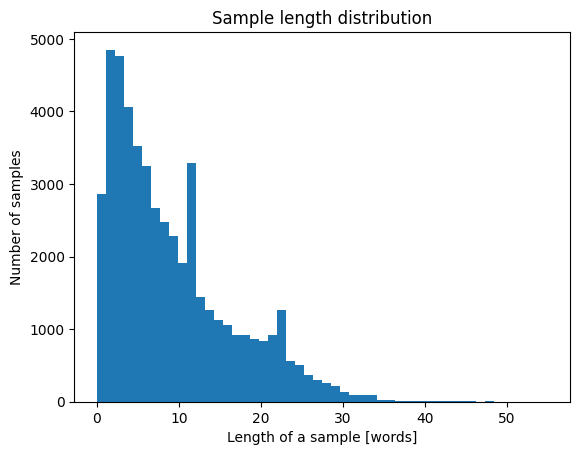

In [23]:
plot_sample_length_distr(tweets_df["text"])

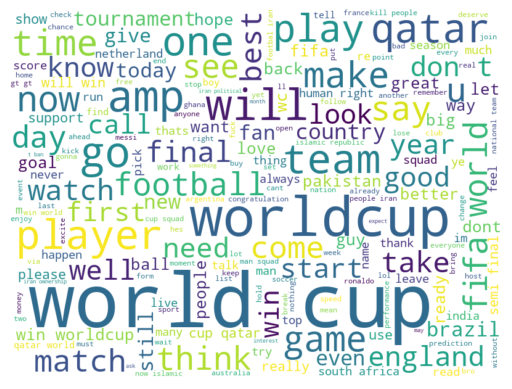

In [24]:
wordcloud = wc.WordCloud(background_color = 'white', width=800, height=600).generate(' '.join(tweets_df["text"]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Tokenization and creating tweets embeddings

In [37]:
from transformers import AutoTokenizer, AutoModel
from datasets import Dataset
import torch

In [72]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# MODEL = f"cardiffnlp/tweet-topic-21-multi"
# #tokenizer = AutoTokenizer.from_pretrained(MODEL)

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")

In [73]:
tweets_df['tokenized'] = ''
tweets_df['tokens'] = ''
tweets_df['attention_mask'] = ''

In [74]:
tokenized_data = tokenizer(tweets_df["text"].values.tolist(), padding=True, truncation=True)
tokenized_data[0]

Encoding(num_tokens=102, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [75]:
i = 0
for row in tweets_df.itertuples():

    tweets_df['tokenized'][i] = tokenized_data[i].ids
    tweets_df['tokens'][i] = tokenized_data[i].tokens
    tweets_df['attention_mask'][i] = tokenized_data[i].attention_mask
    i = i +1

C:\Users\kasia\AppData\Local\Temp\ipykernel_6128\4026262543.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['tokenized'][i] = tokenized_data[i].ids
C:\Users\kasia\AppData\Local\Temp\ipykernel_6128\4026262543.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['tokens'][i] = tokenized_data[i].tokens
C:\Users\kasia\AppData\Local\Temp\ipykernel_6128\4026262543.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twe

In [76]:
tweets_df.head()

ID                                               text  \
0   0   can never world cup uphold basic human right ...   
1   1      french national team announce roster            
2   2  us mens national team  set roster world cup go...   
3   3      sick joke now maddison tomori get man now       
4   4  update quote inter miami defender deandre yedl...   

                                           tokenized  \
0  [0, 2068, 2200, 2092, 2456, 27333, 3941, 2533,...   
1  [0, 2417, 2124, 2140, 14974, 9242, 2, 1, 1, 1,...   
2  [0, 2153, 2277, 2019, 2124, 2140, 2279, 9242, ...   
3  [0, 5309, 8261, 2089, 5510, 10525, 2243, 3423,...   
4  [0, 10655, 14690, 6974, 5635, 8295, 4674, 1620...   

                                              tokens  \
0  [<s>, can, never, world, cup, uphold, basic, h...   
1  [<s>, french, national, team, announce, roster...   
2  [<s>, us, men, ##s, national, team, set, roste...   
3  [<s>, sick, joke, now, mad, ##dis, ##on, tom, ...   
4  [<s>, update, quote, inter, miami, defender, d...   

                                      attention_mask  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1  [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...   
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                          embeddings  
0  [-1.5195792, -0.51415014, -0.12873885, -0.7540...  
1  [0.80879617, 0.350882, 0.9336874, -0.14780162,...  
2  [1.106369, 0.35112098, 0.12985097, -0.6208776,...  
3  [-1.3227913, -1.0376984, -0.1740502, -0.844899...  
4  [-0.83266056, -0.47897574, -1.707079, -0.06869...

In [77]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49309 entries, 0 to 49308
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              49309 non-null  int64 
 1   text            49309 non-null  object
 2   tokenized       49309 non-null  object
 3   tokens          49309 non-null  object
 4   attention_mask  49309 non-null  object
 5   embeddings      49309 non-null  object
dtypes: int64(1), object(5)
memory usage: 3.6+ MB


In [78]:
tweets_df = tweets_df[tweets_df['tokens'].apply(lambda x: len(x) > 3)]
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49309 entries, 0 to 49308
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              49309 non-null  int64 
 1   text            49309 non-null  object
 2   tokenized       49309 non-null  object
 3   tokens          49309 non-null  object
 4   attention_mask  49309 non-null  object
 5   embeddings      49309 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.6+ MB


### Represent text as Doc2Vec

In [79]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

tokenized_texts = tweets_df['tokens'].values.tolist()
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_texts)]
tagged_data[0:2]

[TaggedDocument(words=['<s>', 'can', 'never', 'world', 'cup', 'uphold', 'basic', 'human', 'right', 'put', 'athletes', 'whose', 'job', 'place', 'work', 'in', '##vid', '##ious', 'position', 'fear', 'identity', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], tags=[0]),
 TaggedDocument(words=['<s>', 'french', 'national', 

In [80]:
model = Doc2Vec(vector_size = 20, window = 2, min_count = 1, epochs = 100)

In [81]:
model.build_vocab(tagged_data)

In [84]:
from os.path import exists

model_file = "d2v.model"
file_exists = exists(model_file)

if file_exists:
    model = Doc2Vec.load(model_file)
else:
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
    model.save(model_file)

In [86]:
embeddings = [model.infer_vector(d) for i, d in enumerate(tokenized_texts)]

In [87]:
embeddings[0]

array([-0.90717953, -0.7062514 ,  1.1409572 , -0.01955364,  1.0301944 ,
        0.84084284,  0.46556872,  1.3709323 ,  1.9096837 , -0.9925555 ,
        0.2584542 ,  0.09182664,  1.0299838 , -0.10826588,  0.3605095 ,
        0.526533  ,  1.1896591 ,  0.20667928,  0.26184744, -0.04914989],
      dtype=float32)

In [88]:
tweets_df['embeddings'] = embeddings

In [89]:
tweets_df.head()

ID                                               text  \
0   0   can never world cup uphold basic human right ...   
1   1      french national team announce roster            
2   2  us mens national team  set roster world cup go...   
3   3      sick joke now maddison tomori get man now       
4   4  update quote inter miami defender deandre yedl...   

                                           tokenized  \
0  [0, 2068, 2200, 2092, 2456, 27333, 3941, 2533,...   
1  [0, 2417, 2124, 2140, 14974, 9242, 2, 1, 1, 1,...   
2  [0, 2153, 2277, 2019, 2124, 2140, 2279, 9242, ...   
3  [0, 5309, 8261, 2089, 5510, 10525, 2243, 3423,...   
4  [0, 10655, 14690, 6974, 5635, 8295, 4674, 1620...   

                                              tokens  \
0  [<s>, can, never, world, cup, uphold, basic, h...   
1  [<s>, french, national, team, announce, roster...   
2  [<s>, us, men, ##s, national, team, set, roste...   
3  [<s>, sick, joke, now, mad, ##dis, ##on, tom, ...   
4  [<s>, update, quote, inter, miami, defender, d...   

                                      attention_mask  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1  [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...   
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                          embeddings  
0  [-0.90717953, -0.7062514, 1.1409572, -0.019553...  
1  [0.6487634, -0.25238663, 0.63408005, -0.172471...  
2  [0.6011906, 0.23097171, -1.1504388, -0.3008545...  
3  [-0.7498769, -0.8062827, -0.6790561, -0.555019...  
4  [-1.2379006, -0.19635777, -0.59528935, 0.03908...

## Experiments with DBSCAN

In [90]:
data = pd.DataFrame(tweets_df['embeddings'])
data.head()

embeddings
0  [-0.90717953, -0.7062514, 1.1409572, -0.019553...
1  [0.6487634, -0.25238663, 0.63408005, -0.172471...
2  [0.6011906, 0.23097171, -1.1504388, -0.3008545...
3  [-0.7498769, -0.8062827, -0.6790561, -0.555019...
4  [-1.2379006, -0.19635777, -0.59528935, 0.03908...

### define helper functions

In [91]:
def reduce_dimensionality(df: pd.DataFrame, vec_col_name : str = 'embeddings'):
    data = df.copy()
    data = data.reset_index()
  
    pca = PCA(n_components=3)
    data['x1'] = pca.fit_transform(data[vec_col_name].values.tolist())[:,0]
    data['x2'] = pca.fit_transform(data[vec_col_name].values.tolist())[:,1]
    data['x3'] = pca.fit_transform(data[vec_col_name].values.tolist())[:,2]

    return data[['x1','x2','x3']]

In [92]:
def plot_clusters(data: pd.DataFrame, clusters: list, plt_title: str, plt_title_3d: str, dest_folder: str, save: bool = False):

    # create and save 2d clusters plot ####
    clusters_plt_2d = sns.scatterplot(x = data['x1'], y= data['x2'],hue=clusters,data=data)
    plt.title(plt_title)

    # save
    if save is True:
        fig1 = clusters_plt_2d.get_figure()
        fig1.savefig(f"{dest_folder}\{plt_title}.png")

    # create 3d clusters plot ####

    # axes instance
    fig2 = plt.figure(figsize=(6,6))
    ax = Axes3D(fig2, auto_add_to_figure=False)
    fig2.add_axes(ax)

    # plot
    sc = ax.scatter( data['x1'], data['x2'], data['x3'], s=40, c=clusters, marker='o')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('x3')

    # legend
    plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
    plt.title(plt_title_3d)

    # save
    if save is True:
        plt.savefig(f"{dest_folder}\{plt_title_3d}.png", bbox_inches='tight')

In [93]:
def apply_dbscan(data: pd.DataFrame, eps: int = 0.5, min_pts: int = 5, vec_col_name : str = 'embeddings', dist_measure: str = 'euclidean'):
    
    df = data.copy()
    
    df_cut = df[vec_col_name].apply(pd.Series)
    data_arr = np.array(df_cut)

    clusters, true_centers = ds.dbscan(data_arr, eps = eps, min_points=min_pts, dist_func=dist_measure)
    clusters_counter = Counter(clusters)

    return {'results': {'clusters': clusters, 'cluster_counter': clusters_counter, 'true_centers': true_centers}, 'df_cut': df_cut}

In [94]:
def get_reduced_df(df: pd.DataFrame, vec_col_name : str = 'embeddings'):
    # combine data back into one vector
    source_df = df.copy()
    source_df[vec_col_name] = source_df.values.tolist()

    # reduce dimensionality to 3
    reduced_df = reduce_dimensionality(source_df, vec_col_name)

    return reduced_df

### Experiments with input size, eps and min points params

#### input: first 2500 tweets

In [110]:
df_slice = data.loc[0:2499]
df_slice.count()

embeddings    2500
dtype: int64

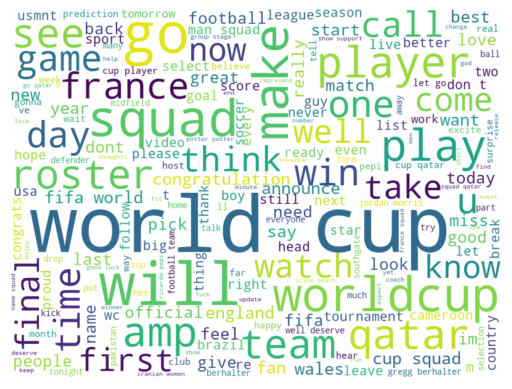

In [111]:
wordcloud = wc.WordCloud(background_color = 'white', width=800, height=600).generate(' '.join(tweets_df["text"][0:2499]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

##### attempt 1 : eps = 0.5, min_pts: 5

In [140]:
results = apply_dbscan(data = df_slice, eps = 0.5, min_pts=41)
results['results']['cluster_counter']

Counter({-1: 4846, 1: 154})

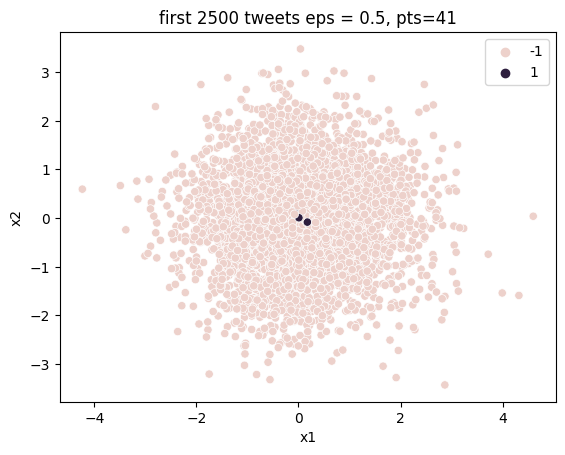

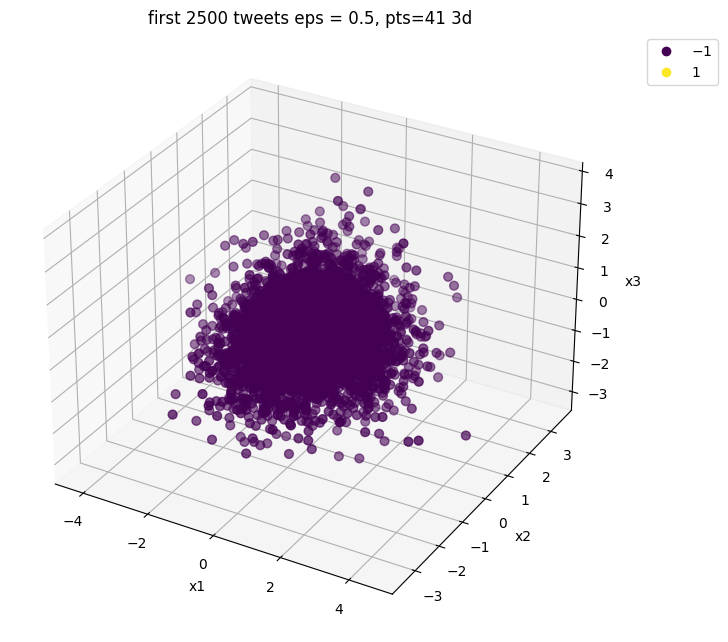

In [141]:
data_to_visualize = get_reduced_df(results['df_cut']) 
plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = 'first 2500 tweets eps = 0.5, pts=41',
 plt_title_3d = 'first 2500 tweets eps = 0.5, pts=41 3d', dest_folder = 'plots', save = True)

##### attempt 2 : eps = 1, min_pts: 5

In [142]:
results = apply_dbscan(data = df_slice, eps = 1, min_pts=41)
results['results']['cluster_counter']

Counter({-1: 4682, 2: 156, 1: 162})

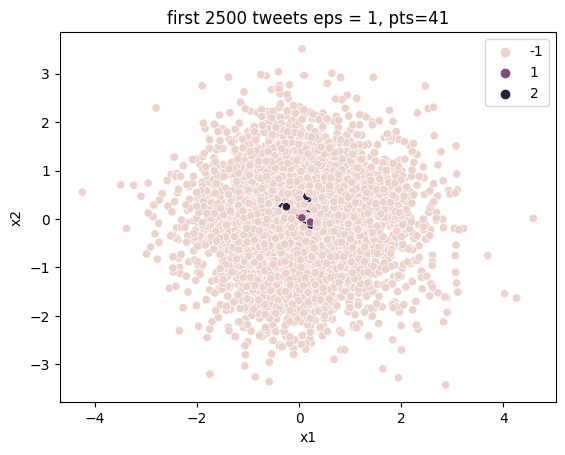

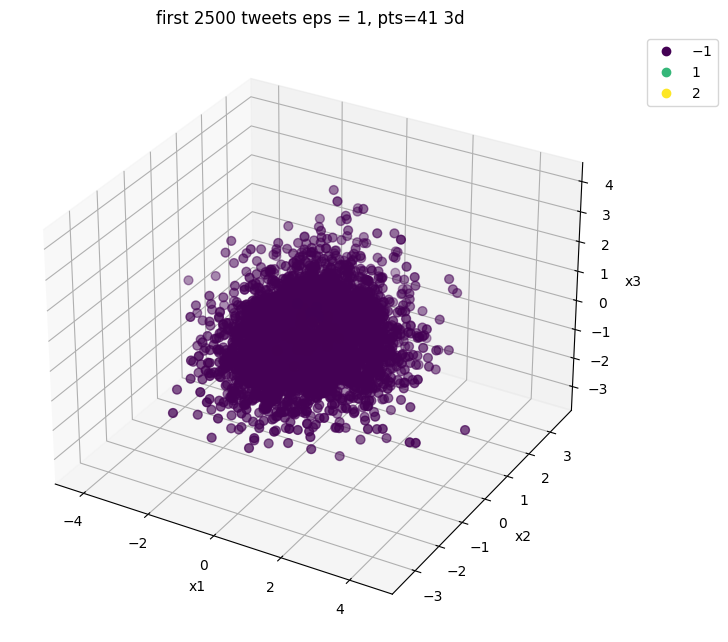

In [143]:
data_to_visualize = get_reduced_df(results['df_cut']) 
plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = 'first 2500 tweets eps = 1, pts=41',
plt_title_3d = 'first 2500 tweets eps = 1, pts=41 3d', dest_folder = 'plots', save = True)

##### attempt 3 : eps = 1.5, min_pts: 5

In [144]:
results = apply_dbscan(data = df_slice, eps = 1.5, min_pts=41)
results['results']['cluster_counter']

Counter({-1: 4179, 1: 821})

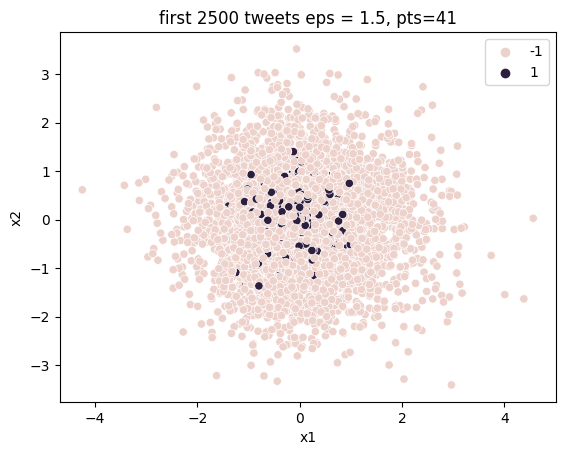

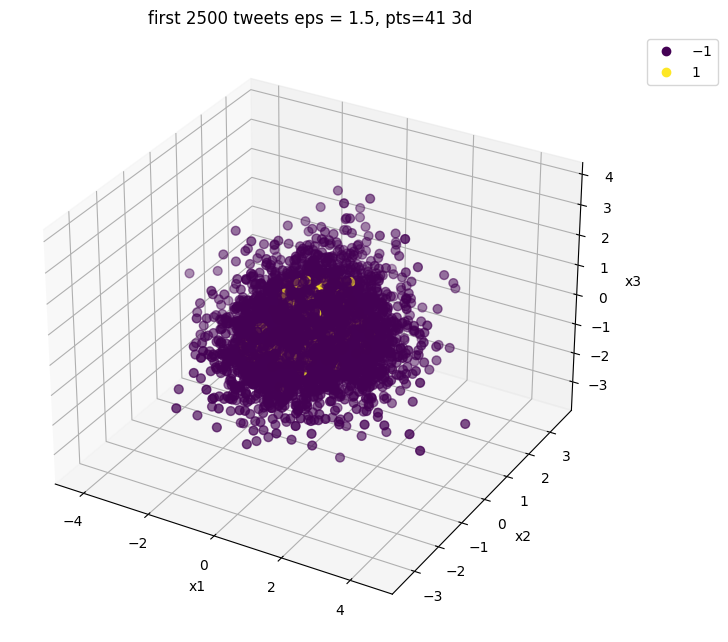

In [145]:
data_to_visualize = get_reduced_df(results['df_cut']) 
plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = 'first 2500 tweets eps = 1.5, pts=41',
plt_title_3d = 'first 2500 tweets eps = 1.5, pts=41 3d', dest_folder = 'plots', save = True)

##### attempt 4 : eps = 2, min_pts: 5

In [146]:
results = apply_dbscan(data = df_slice, eps = 2, min_pts=41)
results['results']['cluster_counter']

Counter({-1: 2579, 1: 2421})

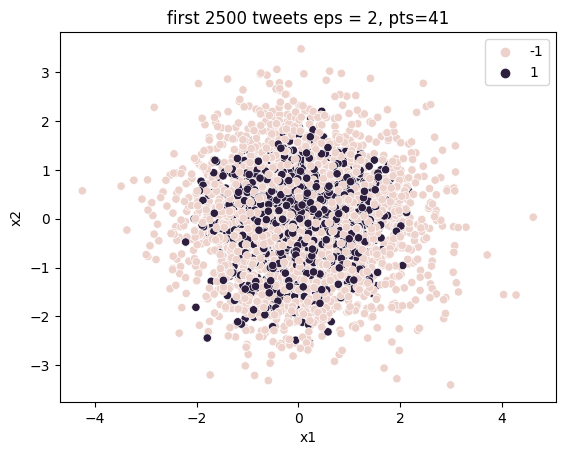

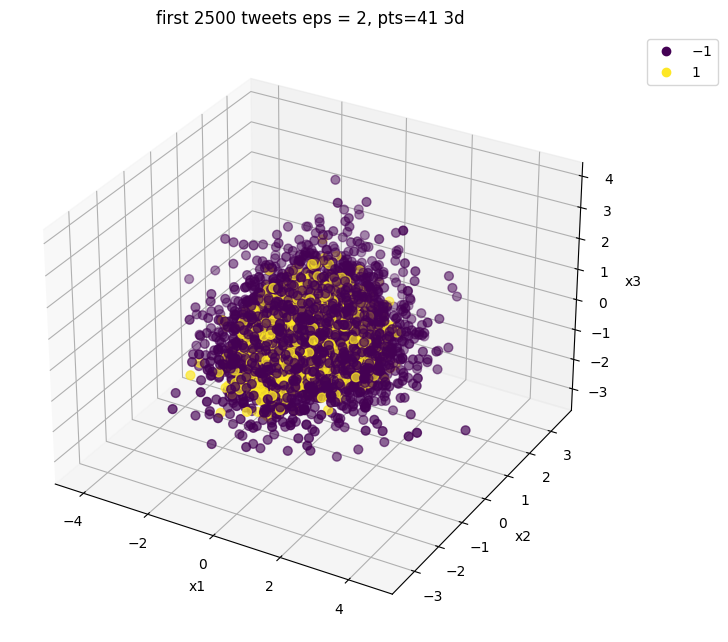

In [147]:
data_to_visualize = get_reduced_df(results['df_cut']) 
plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = 'first 2500 tweets eps = 2, pts=41',
plt_title_3d = 'first 2500 tweets eps = 2, pts=41 3d', dest_folder = 'plots', save = True)

#### input: first 5000 tweets

In [148]:
df_slice = data.loc[0:4999]
df_slice.count()

embeddings    5000
dtype: int64

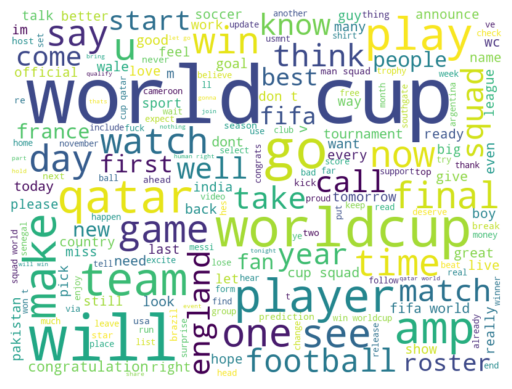

In [149]:
wordcloud = wc.WordCloud(background_color = 'white', width=800, height=600).generate(' '.join(tweets_df["text"][0:4999]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

##### attempt 1: eps = 0.5, min_pts = 5

In [150]:
results = apply_dbscan(data = df_slice, eps = 0.5, min_pts=41)
results['results']['cluster_counter']

Counter({-1: 4846, 1: 154})

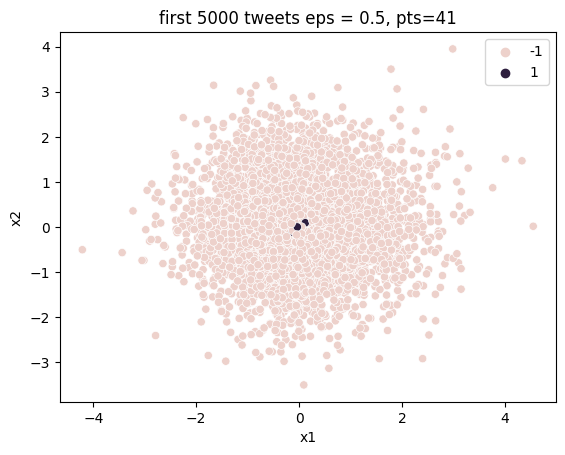

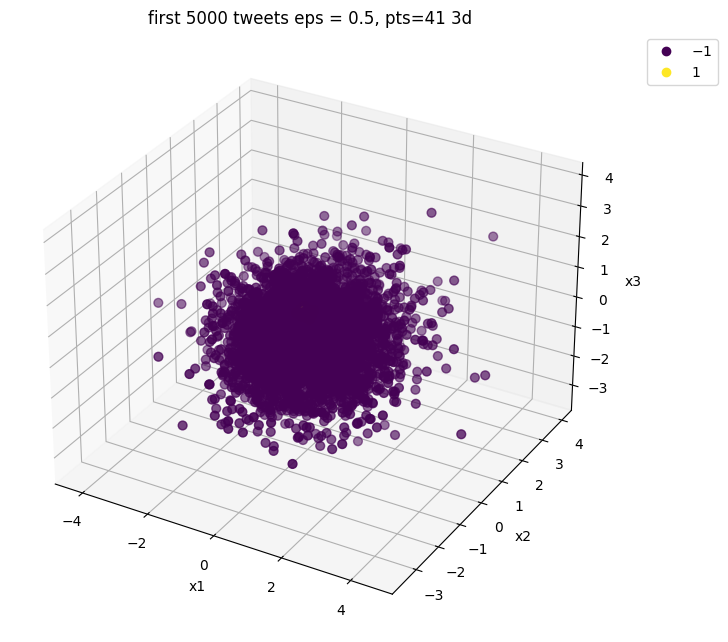

In [151]:
data_to_visualize = get_reduced_df(results['df_cut']) 
plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = 'first 5000 tweets eps = 0.5, pts=41',
 plt_title_3d = 'first 5000 tweets eps = 0.5, pts=41 3d', dest_folder = 'plots', save = True)

##### attempt 2 : eps = 1, min_pts: 5

In [152]:
results = apply_dbscan(data = df_slice, eps = 1, min_pts=41)
results['results']['cluster_counter']

Counter({-1: 4682, 2: 156, 1: 162})

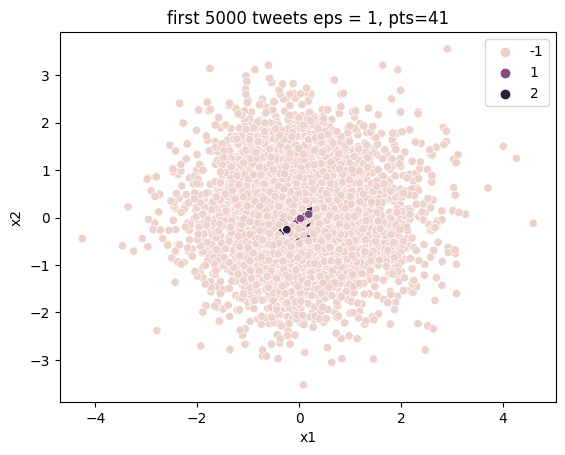

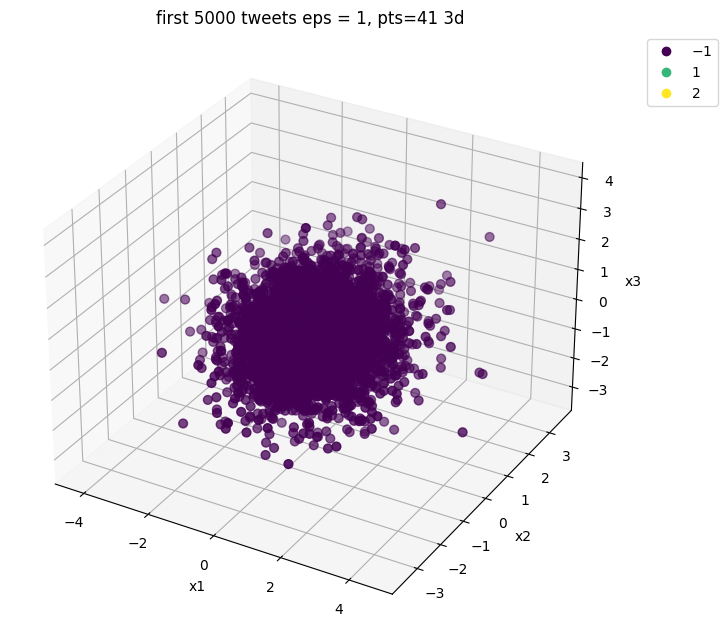

In [153]:
data_to_visualize = get_reduced_df(results['df_cut']) 
plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = 'first 5000 tweets eps = 1, pts=41',
plt_title_3d = 'first 5000 tweets eps = 1, pts=41 3d', dest_folder = 'plots', save = True)

##### attempt 3 : eps = 1.5, min_pts: 5

In [154]:
results = apply_dbscan(data = df_slice, eps = 1.5, min_pts=41)
results['results']['cluster_counter']

Counter({-1: 4179, 1: 821})

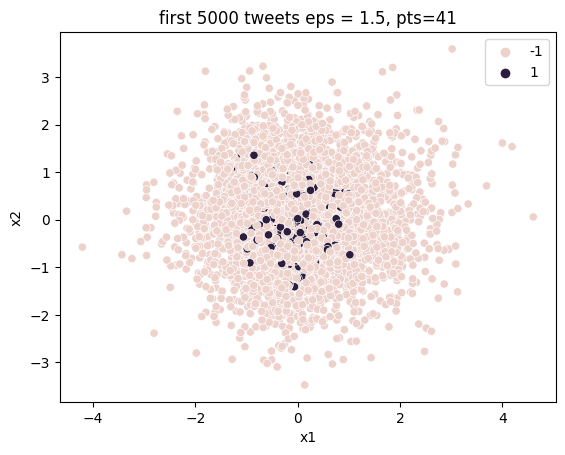

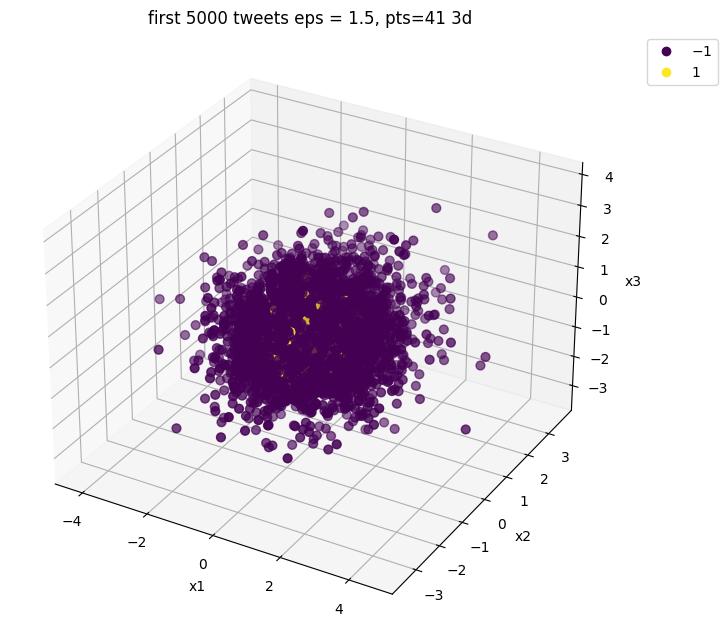

In [155]:
data_to_visualize = get_reduced_df(results['df_cut']) 
plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = 'first 5000 tweets eps = 1.5, pts=41',
plt_title_3d = 'first 5000 tweets eps = 1.5, pts=41 3d', dest_folder = 'plots', save = True)

##### attempt 4 : eps = 2, min_pts: 5

In [156]:
results = apply_dbscan(data = df_slice, eps = 2, min_pts=41)
results['results']['cluster_counter']

Counter({-1: 2579, 1: 2421})

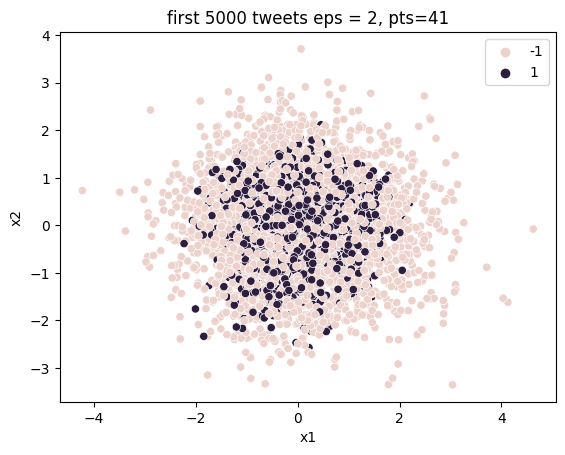

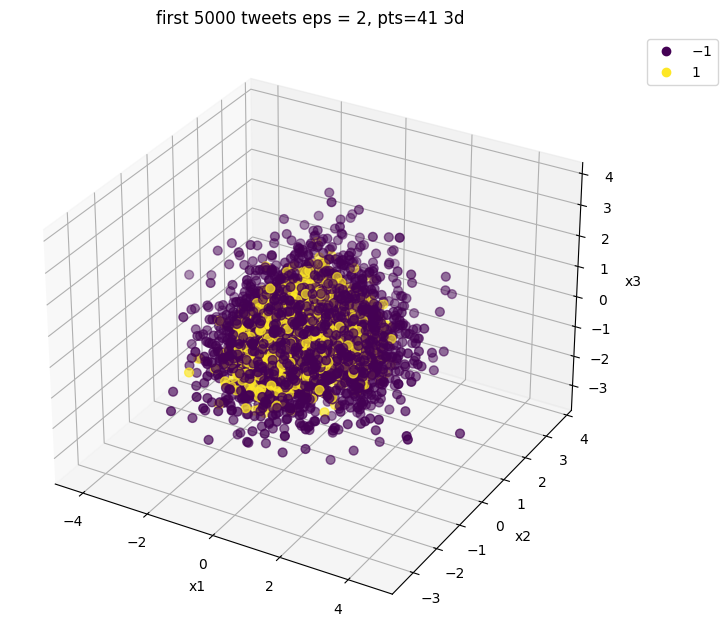

In [157]:
data_to_visualize = get_reduced_df(results['df_cut']) 
plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = 'first 5000 tweets eps = 2, pts=41',
plt_title_3d = 'first 5000 tweets eps = 2, pts=41 3d', dest_folder = 'plots', save = True)

In [158]:
results = apply_dbscan(data = df_slice, eps = 0.7, min_pts=41)
results['results']['cluster_counter']

Counter({-1: 4780, 1: 156, 2: 64})

In [159]:
results = apply_dbscan(data = df_slice, eps = 1, min_pts=41)
results['results']['cluster_counter']

Counter({-1: 4682, 2: 156, 1: 162})

In [160]:
results = apply_dbscan(data = df_slice, eps = 1.5, min_pts=41)
results['results']['cluster_counter']

Counter({-1: 4179, 1: 821})

In [161]:
results = apply_dbscan(data = df_slice, eps = 1.5, min_pts=41)
results['results']['cluster_counter']

Counter({-1: 4179, 1: 821})

#### input: first 15000 tweets

In [162]:
df_slice = data.loc[0:14999]
df_slice.count()

embeddings    15000
dtype: int64

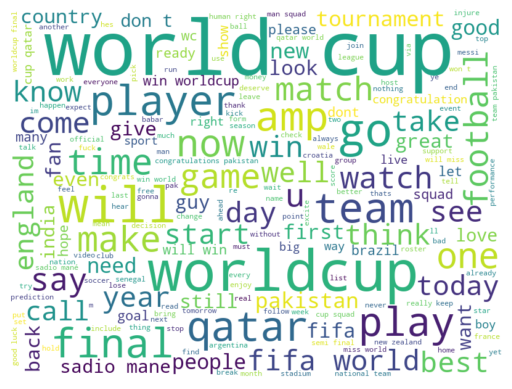

In [163]:
wordcloud = wc.WordCloud(background_color = 'white', width=800, height=600).generate(' '.join(tweets_df["text"][0:14999]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

##### eps = 1, min pts = 41

In [ ]:
results = apply_dbscan(data = df_slice, eps = 1, min_pts=41)
results['results']['cluster_counter']

In [ ]:
data_to_visualize = get_reduced_df(results['df_cut']) 
plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = 'first 15000 tweets eps = 1, pts=41',
 plt_title_3d = 'first 15000 tweets eps = 1, pts=41 3d', dest_folder = 'plots', save = True)

##### eps = 1.5, min pts = 41

In [ ]:
results = apply_dbscan(data = df_slice, eps = 1.5, min_pts=41)
results['results']['cluster_counter']

In [ ]:
data_to_visualize = get_reduced_df(results['df_cut']) 
plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = 'first 5000 tweets eps = 1.5, pts=41',
 plt_title_3d = 'first 5000 tweets eps = 1.5, pts=41 3d', dest_folder = 'plots', save = True)